# Libraries and paths

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.metrics import classification_report

In [4]:
#Checking if GPU can be used for Torch:
torch.cuda.is_available()

True

In [5]:
# Path to the dataset
data_dir = 'Rice_Image_Dataset'

# Splitting dataset into Train, Test and Val

In [7]:
classes = os.listdir(data_dir)

# Desired split
train_size = 0.7
val_size = 0.15
# Note: test_size is implicitly determined as the remaining portion

# Creating directories for the split dataset if they don't exist
for split in ['train', 'val', 'test']:
    for class_name in classes:
        os.makedirs(os.path.join(data_dir, split, class_name), exist_ok=True)

for class_name in classes:
    # Listing all files in the directory
    files = os.listdir(os.path.join(data_dir, class_name))
    files = [os.path.join(data_dir, class_name, f) for f in files]
    
    # Splitting the files
    train_files, test_files = train_test_split(files, train_size=train_size, random_state=42)
    val_files, test_files = train_test_split(test_files, train_size=val_size / (1 - train_size), random_state=42)
    
    # Function to copy the files to the respective directory
    def copy_files(files, split):
        for f in files:
            shutil.copy(f, os.path.join(data_dir, split, class_name))
            
    copy_files(train_files, 'train')
    copy_files(val_files, 'val')
    copy_files(test_files, 'test')

print('Dataset successfully split into train, val, and test sets.')

Dataset successfully split into train, val, and test sets.


# Data Loading and Transformation

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ResNet-50 input dimensions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_set = ImageFolder(f"{data_dir}/train", transform=transform)
test_set = ImageFolder(f"{data_dir}/test", transform=transform)
val_set = ImageFolder(f"{data_dir}/val", transform=transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# Model Preparation

In [10]:
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
num_classes = len(train_set.classes)  # Assuming all classes are represented in the training set
model.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\bbnfa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bbnfa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\bbnfa/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 85.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Functions

In [11]:
#Training function
def train(model, criterion, optimizer, loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

#Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

# Training

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, criterion, optimizer, train_loader, epochs=10)

Epoch 1/10, Loss: 0.07281826436519623
Epoch 2/10, Loss: 0.020482327789068222
Epoch 3/10, Loss: 0.0017466541612520814
Epoch 4/10, Loss: 0.0002352316805627197
Epoch 5/10, Loss: 0.000761721923481673
Epoch 6/10, Loss: 0.000340642494847998
Epoch 7/10, Loss: 3.988945172750391e-05
Epoch 8/10, Loss: 0.00028733271756209433
Epoch 9/10, Loss: 0.04798277094960213
Epoch 10/10, Loss: 8.150513895088807e-05


In [13]:
# Saving the model
model_save_path = "fine_tuned_resnet50_rice.pth"
torch.save(model.state_dict(), model_save_path)

In [ ]:
# # Loading the saved model
# # Ensure the model architecture is defined
# model = resnet50(pretrained=False)  # Initialize the model architecture
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)  # Adjust the final layer as per the dataset

# # Load the state dictionary
# model.load_state_dict(torch.load(model_save_path))

# # Move the model to the appropriate device
# model.to(device)


# Evaluation

In [14]:
evaluate(model, val_loader)

Accuracy: 99.68875055580259%


In [15]:
# Classification report
def get_predictions_and_labels(model, loader):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for images, label_batch in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            labels.extend(label_batch.numpy())
    return predictions, labels

# Assuming test_loader is defined and model is loaded and switched to evaluation mode
predictions, true_labels = get_predictions_and_labels(model, test_loader)

# Generating the classification report
print(classification_report(true_labels, predictions, target_names=test_loader.dataset.classes))


              precision    recall  f1-score   support

     Arborio       1.00      0.99      0.99      2251
     Basmati       1.00      1.00      1.00      2251
      Ipsala       1.00      1.00      1.00      2251
     Jasmine       0.99      1.00      1.00      2251
   Karacadag       0.99      1.00      1.00      2251

    accuracy                           1.00     11255
   macro avg       1.00      1.00      1.00     11255
weighted avg       1.00      1.00      1.00     11255



# Prediction

## Label for a random image from test

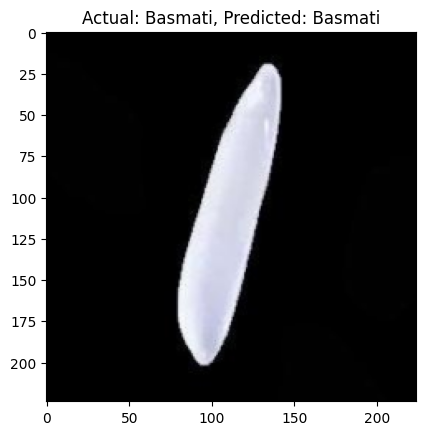

In [16]:
# Prediction function
def predict_random_image(model, dataset):
    model.eval()
    idx = np.random.randint(0, len(dataset))
    image, label = dataset[idx]
    image_unnorm = (image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    image_unnorm = image_unnorm.numpy().transpose((1, 2, 0))
    image = image.unsqueeze(0).to(device)  # Add batch dimension and send to device

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_label = dataset.classes[predicted.item()]

    plt.imshow(image_unnorm)
    plt.title(f'Actual: {dataset.classes[label]}, Predicted: {predicted_label}')
    plt.show()

predict_random_image(model, test_set)


## Class probability for a random image from test

Predicted label: Arborio
Probabilities:
Arborio: 99.89%
Basmati: 0.00%
Ipsala: 0.00%
Jasmine: 0.11%
Karacadag: 0.00%


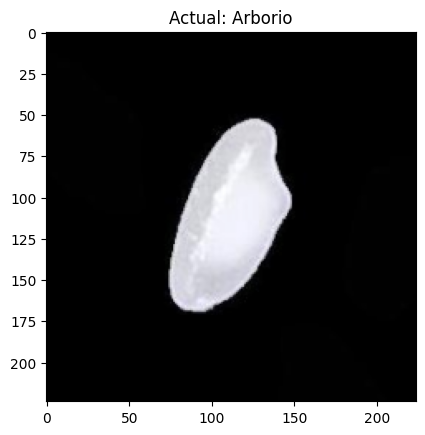

In [17]:
def predict_random_image_with_probabilities(model, dataset):
    model.eval()
    idx = np.random.randint(0, len(dataset))
    image, label = dataset[idx]
    image_unnorm = (image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    image_unnorm = image_unnorm.numpy().transpose((1, 2, 0))
    image = image.unsqueeze(0).to(device)  # Add batch dimension and send to device

    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        predicted_label = dataset.classes[torch.argmax(probabilities).item()]

    print(f"Predicted label: {predicted_label}")
    print("Probabilities:")
    for i, prob in enumerate(probabilities.squeeze()):
        print(f"{dataset.classes[i]}: {prob.item()*100:.2f}%")
    
    plt.imshow(image_unnorm)
    plt.title(f'Actual: {dataset.classes[label]}')
    plt.show()
    
predict_random_image_with_probabilities(model, test_set)